# ImmoCheck

Wir wollen den Vergleich aufstellen ob die Kaufpreise für Wohnungen (Preise pro m²) und die Einwohnerzahlen sich gleichermaßen verändert haben (Korrelation). \
Dafür begrenzen wir uns auf das Gebiet der Stadt Wien und den Zeitraum von 2015 bis 2023/'24. \
Wir beziehen unsere Daten von 3 Quellen:
- Einwohnerzahlen 2015-2023 (Eurostat API)
- Kaufpreise 2015-2022 (Statistik Austria ods Files)
- Kaufpreise 2024 (Webscraping immobilionscout24.at) 

Jede Datenquelle wird für sich analyisiert und abschließend werden diese verglichen und aus den Ergebnissen Schlüsse gezogen.
Let's get started!

## Imports

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import max, median, round
import pyspark 
import matplotlib.pyplot as plt
import json
from kafka import KafkaProducer
from pyspark.sql.functions import *
from time import sleep
from IPython.display import clear_output

ModuleNotFoundError: No module named 'kafka'

In [29]:
!pip install pdfplumber pandas openpyxl odfpy

## Data Gathering

Jede Datenquelle wird hier für sich importiert (Load Data) und kurz analysiert (Analysis).

### Webscarping - Current cost of real estate

#### Load Data

Um die derzeitigen Wohnungspreise pro m² zu bekommen, werden die Daten von "Immobilienscout24.at" gescraped.

In [30]:
i = 1
url = ""
prices = []
while True:
    if i == 1:
        url = 'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen'
    else:
        url = f'https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-{i}'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    postings = soup.find_all('li', {'class': 'Item-item-S33'})
    i += 1
    scraped_vals = 0
    for ele in postings:
        for ele2 in (ele.select('a > section > section:nth-of-type(2) > ul:nth-of-type(1) > li:nth-of-type(2)')):
            prices.append(ele2.getText())
            scraped_vals += 1
    if postings == []:
        break;

    print(url,' scraped values:',scraped_vals)

https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen  scraped values: 13
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-2  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-3  scraped values: 13
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-4  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-5  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-6  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-7  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-8  scraped values: 14
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-9  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnung-kaufen/seite-10  scraped values: 15
https://www.immobilienscout24.at/regional/wien/wien/wohnu

Die gescrapten Werte werden in ein pandas DataFrame geladen.

In [60]:
export_dict = {'vals':prices}
export_df = pd.DataFrame(export_dict)
export_df.head(10)

,vals
0,"ab 5.189,5 €/m²"
1,"ab 7.591,67 €/m²"
2,"ab 2.468,11 €/m²"
3,"ab 8.353,58 €/m²"
4,"ab 16.479,28 €/m²"
5,"ab 9.035,75 €/m²"
6,"ab 5.395,68 €/m²"
7,"ab 7.409,54 €/m²"
8,ab 4.921 €/m²
9,"ab 5.937,36 €/m²"


Schaut schon ganz gut aus, aber für weitere Analysen brauchen wir nur die Werte.

In [61]:
export_df = export_df.replace('ab','',regex = True)
export_df = export_df.replace('€/m²','',regex = True)
export_df = export_df.replace(' ','',regex = True)
export_df.head(10)

,vals
0,"5.189,5"
1,"7.591,67"
2,"2.468,11"
3,"8.353,58"
4,"16.479,28"
5,"9.035,75"
6,"5.395,68"
7,"7.409,54"
8,4.921
9,"5.937,36"


Jetzt muss nur noch das Format angepasst werden.

In [62]:
export_df = export_df.apply(lambda x: x.str.replace('.',''))
export_df = export_df.replace(',','.',regex = True)
export_df.head(10)

,vals
0,5189.5
1,7591.67
2,2468.11
3,8353.58
4,16479.28
5,9035.75
6,5395.68
7,7409.54
8,4921
9,5937.36


Die meisten der Werte schauen gut aus. Einige gescrapte Werte können nicht weiter verarbeitet werden und werden deswegen gelöscht.

In [63]:
export_df[export_df['vals'].str.startswith('statt')]

,vals
98,statt279000€-10%
99,statt458000€-14%
130,statt229000€-10%
134,statt269000€-9%
211,statt515000€-5%
214,statt990000€-9%
268,statt539000€-8%
279,statt369000€-8%
297,statt315000€-6%
436,statt270000€-8%


Die Daten wurden gelöscht.

In [64]:
export_df = export_df.drop([98,99,130,134,211,214,268,279,297,436,474,491,506,589])

Daten schauen gut aus und können in ein csv exportiert werden.

In [65]:
export_df.to_csv('./exports/prices.csv', index=False)  

#### Kafka

Die aktuellen Kosten pro Quadratmeter werden in ein Kafka Topic geladen. Wir möchten somit das Potenzial schaffen, von weiteren Immobilien Seiten Daten zu scrapen und mit auszuwerten.

In [202]:
!docker-compose up -d

 Network immocheck_default  Creating
 Network immocheck_default  Created
 Container immocheck-kafka-1  Creating
 Container immocheck-kafka-1  Created
 Container immocheck-init-kafka-1  Creating
 Container immocheck-init-kafka-1  Created
 Container immocheck-kafka-1  Starting
 Container immocheck-kafka-1  Started
 Container immocheck-kafka-1  Waiting
 Container immocheck-kafka-1  Healthy
 Container immocheck-init-kafka-1  Starting
 Container immocheck-init-kafka-1  Started


Nachdem der Docker container gestartet wurde, laden wir unsere Daten in das Topic "prices".

(Da wir auch das Streamen einbauen wollen, laden wir hier nur 10 Datensätze, der Rest wird später in das Topic gealden um das Streamen bei einer Visiualisierung zu zeigen)

Der Producer wird erstellt:

In [203]:
producer = KafkaProducer(bootstrap_servers='localhost:9094')

Die Daten werden vom csv in einen Pandas Dataframe geladen.

In [205]:
input_file = pd.read_csv("./exports/prices.csv")

Die ersten 10 Datensätze werden and das Topic "prices" gesendet:

In [206]:
for x in range(10):
  producer.send('prices', value=input_file['vals'][x].astype(str).encode('utf-8'))
  print(input_file['vals'][x].astype(str))

5189.5
7591.67
2468.11
8353.58
16479.28
9035.75
5395.68
7409.54
4921.0
5937.36


Speichern, wie viele Datensätze im Dataframe enthalten sind. Später für das Senden der restlichen Daten wichtig.

In [207]:
vals_count = test.shape[0]
vals_count

591

#### Analysis

Um ein tieferes Verständnis der Daten aufzubauen wollen wir uns Visulisierungen zu nutze machen. Deswegen müssen wir die bereits strukturierten und bereinigte Daten laden. Dazu erstellen wir zuerst eine Spark Session.

In [225]:
spark = (SparkSession
         .builder
         .appName('ImmoCheck')
         .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1")
         .getOrCreate())
sc = spark.sparkContext

In [135]:
spark

Es muss definiert werden, von wo der Dataframe die Daten bezieht. In unserem Fall von einem Kafka container, darin ist ein Topic namens "prices".

In [226]:
df = (spark
  .readStream
  .format("kafka")
  .option("kafka.bootstrap.servers", "localhost:9094")
  .option("subscribe", "prices")
  .option("startingOffsets", "earliest")
  .load())

Wir benötigen nur die Werte des Streams.

In [227]:
parsed_df = df \
    .selectExpr("CAST(value AS STRING)") \
    .select("value").alias("data") \
    .select("data.*")

Der Durchscnitt wird errechnet:

In [228]:
windowed_counts = parsed_df.agg(
    median(col("value").cast("float")).alias("price_median"),
)

Die Query wird abgesetzt und die Daten werden nun gestreamed.

In [229]:
query = windowed_counts \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("pricesStream") \
    .start()

In [214]:
spark.table("pricesStream").show()

+-----------------+
|     price_median|
+-----------------+
|6673.449951171875|
+-----------------+


Vislualisierung + restliche Daten laden

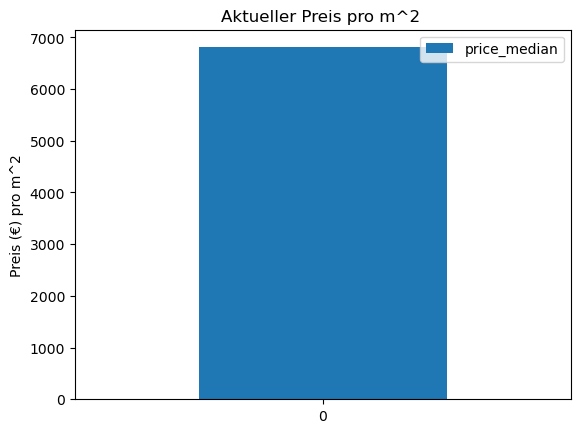

KeyboardInterrupt: 

In [230]:
# Die ersten 10 Datensätze wurden schon ins Topic geladen
# Deswegen wird alles ab Datensatz 11 geladen
start_row = 11

while True:

    df_median = spark.sql(
        """
        SELECT price_median FROM pricesStream
        """).toPandas()
    
    
    # Plot the bar graph
    ax = df_median.plot(kind='bar')
    ax.set_ylabel('Preis (€) pro m^2')
    ax.set_title('Aktueller Preis pro m^2 ')
    plt.xticks(rotation=0) 

    clear_output(wait=True)
    plt.show()

    sleep(3) #test
    for x in range(start_row,vals_count):
        producer.send('prices', value=input_file['vals'][x].astype(str).encode('utf-8'))
   
    producer.flush()

    # Damit das Ergebnis nicht verfälscht wird, falls die schleife länger läuft
    start_row = 1

In [ ]:
query.stop()
spark.stop()

In [231]:
df_median = df_median.round(0)
df_median

,price_median
0,6809.0


Der Median für unser Datenset beträgt € 6809 pro m².

Eine kleine Auflockerung dazwischen:
Was ist die Lieblingsbeschäftigung von *Bits*?
*Bus*fahren!

### Datasource 2 - Historical cost of real estate

#### Load Data

Zuerst, laden wir uns mit dem ods-reader aus dem ods file den Reiter "Wien".

In [3]:
file_path = './statistik austria/Wohnungspreise2016.ods'
df_wien = pd.read_excel(file_path, engine='odf', sheet_name='Wien', header=[3, 4])

Lasst uns schauen was wir laden konnten:

In [4]:
print(df_wien.head())

         Unnamed: 0_level_0 Wohnfläche nach Baujahr              \
                    Bezirke                Bis 1960  Bis 1960.1   
0                       NaN       Weniger als 56 m²  56 - 80 m²   
1  Wien  1.,Innere Stadt 3)                    5901        5901   
2     Wien  2.,Leopoldstadt                    2533        2532   
3       Wien  3.,Landstraße                    2782        2819   
4           Wien  4.,Wieden                    3050        2944   

                                                                    \
        Bis 1960.2          1961-1990 1961-1990.1      1961-1990.2   
0  Mehr als  80 m²  Weniger als 56 m²  56 - 80 m²  Mehr als  80 m²   
1             5901               4067        4067             4067   
2             2534               2748        2747             2749   
3             2862               2710        2746             2788   
4             3076               2738        2643             2761   

                                       

Wir verwenden die dropna() Methode von pandas um alle Spalten mit "NaN" Werte zu löschen.

In [5]:
df_wien = df_wien.dropna(axis=1, how='all')

Wir fokussieren uns auf die Spalte "Ab 1991.2" und stellen sicher, dass die letzte Spalte ausschließlich nummerische Werte enthält damit wir den Median generieren können.

In [10]:
# save the head of the last column into a variable
last_column = df_wien.columns[-1]

# convert the values into numeric (if not possible they appear as "NaN"
df_wien[last_column] = pd.to_numeric(df_wien[last_column], errors='coerce')

# calculate the mean of the last column (this method ignores "NaN" values
median_value = df_wien[last_column].median()

Lasst uns schauen was der Outcome für 2016 ist:

In [11]:
print(f"Der Median '{last_column[1]}' für 2016 beträgt: {median_value}")

Der Median 'Ab 1991.2' für 2016 beträgt: 4220.5


Jetzt können wir dasselbe für alle Files wiederholen. Dafür kreieren wir zuerst eine Liste die die Tupels Dateipfad und Jahreszahl beinhaltet.

In [12]:
files = [
    ('./statistik austria/Wohnungspreise2016.ods', 2016),
    ('./statistik austria/Wohnungspreise2017.ods', 2017),
    ('./statistik austria/Wohnungspreise2018.ods', 2018),
    ('./statistik austria/Wohnungspreise2019.ods', 2019),
    ('./statistik austria/Wohnungspreise2020.ods', 2020),
    ('./statistik austria/Wohnungspreise2021.ods', 2021),
    ('./statistik austria/Wohnungspreise2022.ods', 2022),
]

Wir definieren die Funktion und führen dieselbe Prozedur für alle Files von 2016 bis 2022 durch:

In [13]:
def calculate_median(file_path, sheet_name='Wien'):
    df = pd.read_excel(file_path, engine='odf', sheet_name=sheet_name, header=[3, 4])
    df = df.dropna(axis=1, how='all')
    last_column = df.columns[-1]
    df[last_column] = pd.to_numeric(df[last_column], errors='coerce')
    return df[last_column].median()

Wir erstellen ein leeres dictionary um die Resultate der Schleife zu speichern und iterieren über die vorherige Funktion 

In [14]:
results = {}

for file_path, year in files:
    median_value = calculate_median(file_path)
    results[year] = median_value

Lasst uns den Outcome anschauen:

In [15]:
print(results)

{2016: 4220.5, 2017: 4464.5, 2018: 4727.0, 2019: 5297.5, 2020: 5539.5, 2021: 5822.0, 2022: 6433.5}


Nur das ods File aus 2015 hat eine etwas andere Struktur, weswegen wir die Werte seperat extrahieren und sie nachher zu den übrigen Werten hinzufügen müssen. Der Start ist ziemlich ähnlich:

In [16]:
file_path_2015 = './statistik austria/Wohnungspreise2015.ods'
sheet_name_2015 = 'Wohnungen_mit_Außenflächen'
df_2015_ohne_außenflächen = pd.read_excel(file_path_2015, engine='odf', sheet_name=sheet_name_2015, header=[2, 3])
df_2015_ohne_außenflächen_cleaned = df_2015_ohne_außenflächen.dropna(axis=1, how='all')

In [17]:
print(df_2015_ohne_außenflächen_cleaned)

                                            Burgenland Wohnflächenkategorien  \
                                               Bezirke      Weniger als 60m²   
0                                           Eisenstadt                  1600   
1                                                Rust*                  1190   
2                                  Eisenstadt-Umgebung                  1190   
3                                              Güssing                   920   
4                                          Jennersdorf                  1260   
..                                                 ...                   ...   
128                                        Brigittenau                  3240   
129                                        Floridsdorf                  3180   
130                                         Donaustadt                  3660   
131                                            Liesing                  3350   
132  Q: STATISTIK AUSTRIA. Erstellt am 2

Wie man sehen kann, gibt es deutlich mehr Zeilen als wie benötigen, weswegen wir uns nur auf die Wiener Bezirke konzentrieren:

In [18]:
vienna_districts_2015 = df_2015_ohne_außenflächen_cleaned[
    df_2015_ohne_außenflächen_cleaned.iloc[:, 0].str.contains(
        'Innere Stadt|Leopoldstadt|Landstraße|Wieden|Margareten|Mariahilf|Neubau|Josefstadt|Alsergrund|Favoriten|Simmering|Meidling|Hietzing|Penzing|Rudolfsheim-Fünfhaus|Ottakring|Hernals|Währing|Döbling|Brigittenau|Floridsdorf|Donaustadt|Liesing',
        na=False
    )
]

In [19]:
print(vienna_districts_2015)

       Burgenland Wohnflächenkategorien                          
          Bezirke      Weniger als 60m² Von 60m² bis 85m² Ab 85m²
109  Innere Stadt                  4530              4810    4550
110  Leopoldstadt                  4030              3690    3640
111    Landstraße                  3960              3680    3920
112        Wieden                  3700              3650    3850
113    Margareten                  3760              3610    3650
114     Mariahilf                  4030              4010    3960
115        Neubau                  4450              4290    4160
116    Josefstadt                  4220              4060    3800
117    Alsergrund                  3550              3720    4110
118     Favoriten                  2880              2800    2790
119     Simmering                  2590              2320    2430
120      Meidling                  3380              3020    3210
121      Hietzing                  3750              3910    3990
122       

Um mögliche Problemen zu verhindern, löschen wir die Kopfzeile(n) und ersetzen sie mit sinnvollem Text:

In [20]:
df_2015_ohne_außenflächen_cleaned = vienna_districts_2015[1:]

df_2015_ohne_außenflächen_cleaned.columns = ['Bezirk', 'Weniger als 60m²', 'Von 60m² bis 85m²', 'Mehr als 85m²']

In [21]:
print(df_2015_ohne_außenflächen_cleaned)

           Bezirk Weniger als 60m² Von 60m² bis 85m² Mehr als 85m²
110  Leopoldstadt             4030              3690          3640
111    Landstraße             3960              3680          3920
112        Wieden             3700              3650          3850
113    Margareten             3760              3610          3650
114     Mariahilf             4030              4010          3960
115        Neubau             4450              4290          4160
116    Josefstadt             4220              4060          3800
117    Alsergrund             3550              3720          4110
118     Favoriten             2880              2800          2790
119     Simmering             2590              2320          2430
120      Meidling             3380              3020          3210
121      Hietzing             3750              3910          3990
122       Penzing             3260              3440          3290
124     Ottakring             3390              3230          

Danach konzentrieren wir uns wieder auf die letzte Spalte, konvertieren diese zu Werten und kalkulieren den Median:

In [22]:
last_column_2015 = vienna_districts_2015.columns[-1]
vienna_districts_2015[last_column_2015] = pd.to_numeric(vienna_districts_2015[last_column_2015], errors='coerce')
median_value_2015 = vienna_districts_2015[last_column_2015].median()

In [23]:
print(f"Der Median für 2015 beträgt: {median_value_2015}")

Der Median für 2015 beträgt: 3680.0


Nachdem wir erfolgreich alle Mediane von 2015 bis 2022 kalkuliert haben, fügen wir diese nun zusammen: 

In [24]:
results[2015] = median_value_2015
print(results)

{2016: 4220.5, 2017: 4464.5, 2018: 4727.0, 2019: 5297.5, 2020: 5539.5, 2021: 5822.0, 2022: 6433.5, 2015: 3680.0}


#### Analysis

Jetzt laden wir alles in ein DataFrame für weitere Analysen:

In [25]:
results_df = pd.DataFrame(list(results.items()), columns=['Year', 'Median']).sort_values('Year').reset_index(drop=True)
print(results_df)

   Year  Median
0  2015  3680.0
1  2016  4220.5
2  2017  4464.5
3  2018  4727.0
4  2019  5297.5
5  2020  5539.5
6  2021  5822.0
7  2022  6433.5


Wir nutzen die Pandas Methode "pct_change()" um die prozentualen Veränderungen des Medians von Jahr zu Jahr zu berechnen und dem DataFrame hinzu zu fügen:

In [26]:
results_df['Percentage Change'] = results_df['Median'].pct_change() * 100

print(results_df)

   Year  Median  Percentage Change
0  2015  3680.0                NaN
1  2016  4220.5          14.687500
2  2017  4464.5           5.781306
3  2018  4727.0           5.879718
4  2019  5297.5          12.068966
5  2020  5539.5           4.568193
6  2021  5822.0           5.099738
7  2022  6433.5          10.503263


Jetzt nutzen wir dies als Basis für unsere Visualisierungen, um ein tieferes Verständnis für die Daten zu erhalten:

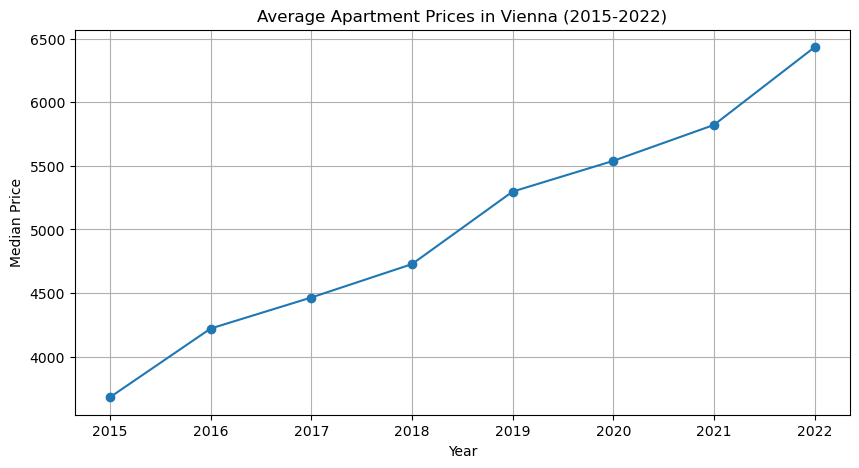

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['Year'], results_df['Median'], marker='o', linestyle='-')
plt.title('Average Apartment Prices in Vienna (2015-2022)')
plt.xlabel('Year')
plt.ylabel('Median Price')
plt.grid(True)
plt.show()

Wir können beobachten wie der Median für Wohnungen in Wien von rund € 3.000,-- in 2015 stetig gestiegen ist und sich beinahe bis 2022 auf fast € 6.500,-- verdoppelt hat.

Lasst uns die totalen Werte des Medians als Säulendiagramm darstellen und die prozentualen Veränderungen auf einer sekundären Achse:

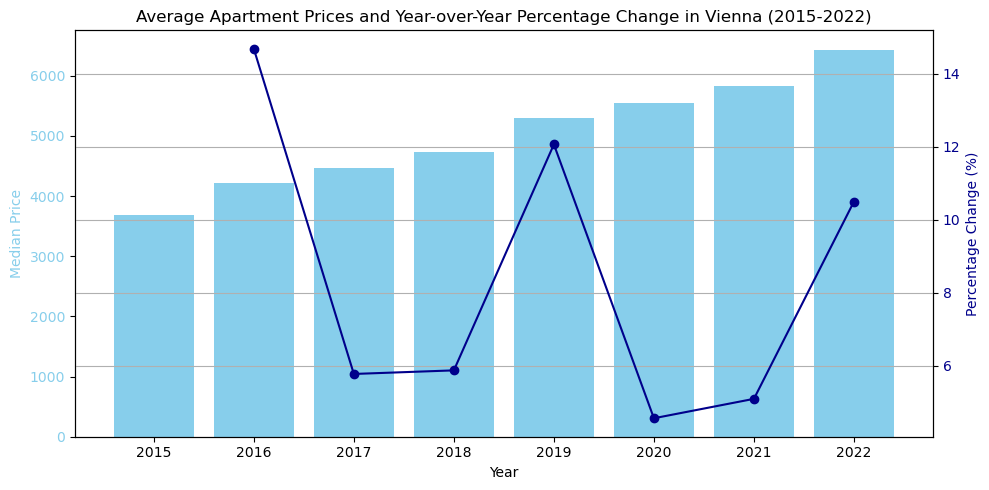

In [28]:
# Plot the median values per year as a bar chart
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(results_df['Year'], results_df['Median'], color='skyblue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Price', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Average Apartment Prices and Year-over-Year Percentage Change in Vienna (2015-2022)')

# Create a secondary y-axis to plot the percentage change
ax2 = ax1.twinx()
ax2.plot(results_df['Year'], results_df['Percentage Change'], color='darkblue', marker='o', linestyle='-')
ax2.set_ylabel('Percentage Change (%)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

fig.tight_layout()  # Ensure everything fits without overlapping
plt.grid(True)
plt.show()

Die stetig steigenden Preise haben einige hohe Ausreisser, wie man in den Jahren '15 zu '16, von '18 zu '19 und auch von '21 zu '22 beobachten kann.

### Datasource 3 - Historical population total 

#### Load Data

Zuerst machen wir einen API Call zu Eurostat, wo wir uns eine Antwort im JSON Format erwarten und haben einen ersten Blick auf die Daten:

In [49]:
url_population = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/demo_r_d2jan?format=JSON&time=2015&time=2016&time=2017&time=2018&time=2019&time=2020&time=2021&time=2022&time=2023&geo=AT&geo=AT1&geo=AT11&geo=AT12&geo=AT13&geo=AT2&geo=AT21&geo=AT22&geo=AT3&geo=AT31&geo=AT32&geo=AT33&geo=AT34&unit=NR&sex=T&age=TOTAL&lang=en"
response = requests.get(url_population)
data = response.json()
print(json.dumps(data, indent=4))

{
    "version": "2.0",
    "class": "dataset",
    "label": "Population on 1 January by age, sex and NUTS 2 region",
    "source": "ESTAT",
    "updated": "2024-05-16T23:00:00+0200",
    "value": {
        "0": 8584926,
        "1": 8700471,
        "2": 8772865,
        "3": 8822267,
        "4": 8858775,
        "5": 8901064,
        "6": 8932664,
        "7": 8978929,
        "8": 9104772,
        "9": 3722471,
        "10": 3784928,
        "11": 3825277,
        "12": 3852119,
        "13": 3868466,
        "14": 3889914,
        "15": 3907838,
        "16": 3927972,
        "17": 4001720,
        "18": 288356,
        "19": 291011,
        "20": 291942,
        "21": 292675,
        "22": 293433,
        "23": 294436,
        "24": 296010,
        "25": 297583,
        "26": 301250,
        "27": 1636778,
        "28": 1653691,
        "29": 1665753,
        "30": 1670668,
        "31": 1677542,
        "32": 1684287,
        "33": 1690879,
        "34": 1698796,
        "35": 1

Wie man sehen kann, haben wir einen Haufen Daten, den wir erst vernünftig für unser Vorhaben strukturieren müssen:

In [51]:
pd.set_option('display.max_rows', None)
# Extrahiert die Jahre aus den JSON-Daten und speichert sie in der Variablen years
years = data['dimension']['time']['category']['label'].keys()
# Erstellen der Listen regions und geocodes
regions = []
geocodes = []
# Befüllen der Listen
for x in data['dimension']['geo']['category']['label'].values():
    for y in range(9):
        regions.append(x)

for x in data['dimension']['geo']['category']['label'].keys():
    for y in range(9):
        geocodes.append(x)

# Erstellen eines DataFrames 
population = pd.DataFrame(
    {'GeoCode' : geocodes,
     'Region' : regions,
     'Year': list(years) * 13, #  wiederholt für jede Region
     'Population': list(data['value'].values())
     }
)

In [54]:
print(population)

    GeoCode            Region  Year  Population
0        AT           Austria  2015     8584926
1        AT           Austria  2016     8700471
2        AT           Austria  2017     8772865
3        AT           Austria  2018     8822267
4        AT           Austria  2019     8858775
5        AT           Austria  2020     8901064
6        AT           Austria  2021     8932664
7        AT           Austria  2022     8978929
8        AT           Austria  2023     9104772
9       AT1     Ostösterreich  2015     3722471
10      AT1     Ostösterreich  2016     3784928
11      AT1     Ostösterreich  2017     3825277
12      AT1     Ostösterreich  2018     3852119
13      AT1     Ostösterreich  2019     3868466
14      AT1     Ostösterreich  2020     3889914
15      AT1     Ostösterreich  2021     3907838
16      AT1     Ostösterreich  2022     3927972
17      AT1     Ostösterreich  2023     4001720
18     AT11        Burgenland  2015      288356
19     AT11        Burgenland  2016     

Damit haben wir erfolgreich die Daten für alle Regionen in Österreich, für alle Jahre die wir benötigen, extrahiert. Für unser Vorhaben wollen wir uns nur auf "Wien" konzentrieren:

In [55]:
vienna_population = population[population['Region'] == 'Wien']

print(vienna_population)

   GeoCode Region  Year  Population
36    AT13   Wien  2015     1797337
37    AT13   Wien  2016     1840226
38    AT13   Wien  2017     1867582
39    AT13   Wien  2018     1888776
40    AT13   Wien  2019     1897491
41    AT13   Wien  2020     1911191
42    AT13   Wien  2021     1920949
43    AT13   Wien  2022     1931593
44    AT13   Wien  2023     1982097


Zu guter Letzt, löschen wir die Spalte "GeoCode" und fügen stattdessen die prozentuellen Veränderungen pro Jahr hinzu:

In [57]:
population = vienna_population.drop(columns=['GeoCode'])

population['Percentage Change'] = population['Population'].pct_change() * 100

print(population)

   Region  Year  Population  Percentage Change
36   Wien  2015     1797337                NaN
37   Wien  2016     1840226           2.386253
38   Wien  2017     1867582           1.486557
39   Wien  2018     1888776           1.134836
40   Wien  2019     1897491           0.461410
41   Wien  2020     1911191           0.722006
42   Wien  2021     1920949           0.510572
43   Wien  2022     1931593           0.554101
44   Wien  2023     1982097           2.614629


Nun nutzen wir dies als Basis für unsere Visualisierungen und tauchen tiefer in die Daten ein:

#### Analysis

Wir visualisieren die Bevölkerungsentwicklung nun als Liniendiagramm:

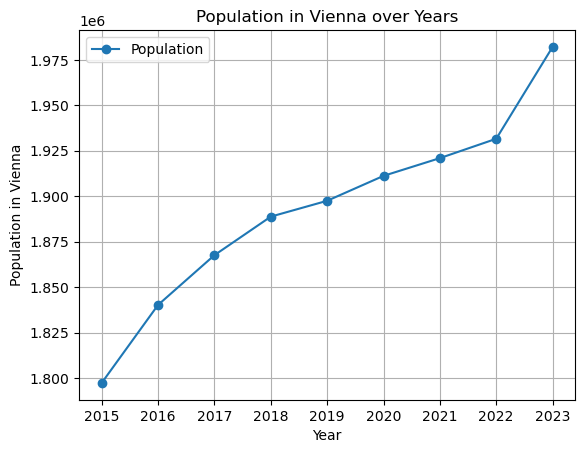

In [74]:
plt.plot(population['Year'], population['Population'], marker='o', label='Population')
plt.xlabel('Year')
plt.ylabel('Population in Vienna')
plt.title('Population in Vienna over Years')
plt.grid(True)
plt.legend()
plt.show()

Als erstes muss festgestellt werden, dass wir hier keine Daten für 2024 haben, dafür jedoch Daten von 2023, welche ebenfalls einen signifikanten Anstieg in diesem Jahr darstellen. Zuvor schien das Bevölkerungswachstum ein wenig abzuflachen und nach einem starken Wachstum in den Jahren von 2015 bis 2018 fiel es zwischen 2018 und 2022 nicht so stark aus.

## Gerneral Analysis

### Cost of real estate (2015 - 2024)

Zuerst kombinieren wir die historischen Kosten für Eigentum (2015-2022) mit den aktuellen. 

In [187]:
#Median von CSV/Kafka importieren
median_2024 = df_median['price_median'][0]

# Die neue Zeile für 2024 erstellen
val_2024 = pd.DataFrame({'Year': [2024], 'Median': [median_2024], 'Percentage Change': [None]})

# Zeile zum DataFrame hinzufügen
all_results = pd.concat([results_df, val_2024], ignore_index=True)

# DataFrame anzeigen
print(all_results)

#Fehlermeldung kann ignoriert werden.

NameError: name 'results_df' is not defined

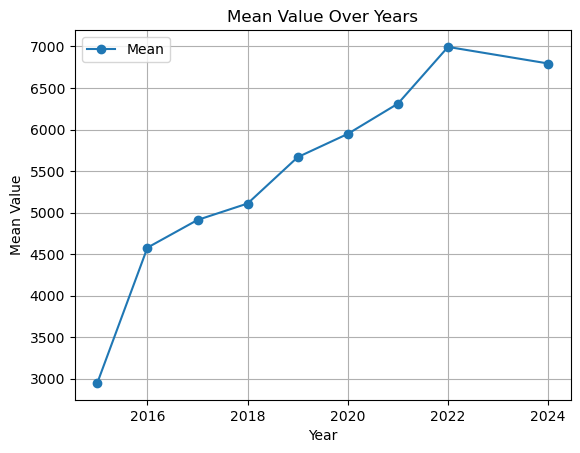

In [71]:
plt.plot(all_results['Year'], all_results['Median'], marker='o', label='Median')
plt.xlabel('Year')
plt.ylabel('Median Value')
plt.title('Median Value Over Years')
plt.grid(True)
plt.legend()
plt.show()

Es zeigt sich das die aktuellen Daten auf einen leichten Abfall nach 2022 hindeuten. Zuvor stiegen der Median der Eigentumskosten pro m² kontinuirlich an. Der stärkste Anstieg ist ganz am Anfang der Daten von 2015 auf 2016 zu erkennen. Danach folgte ein kontinuirlicher Anstieg, welcher laut diesen Daten 2022 zum Stoppen kam und sich in einen leichten Abfall für 2024 umwandelte.

### Comparison with population growth

Nun vergleichen wir den Wachstum der Bevölkerung mit dem Anstieg der durchschnittlichen Eigentumskosten.

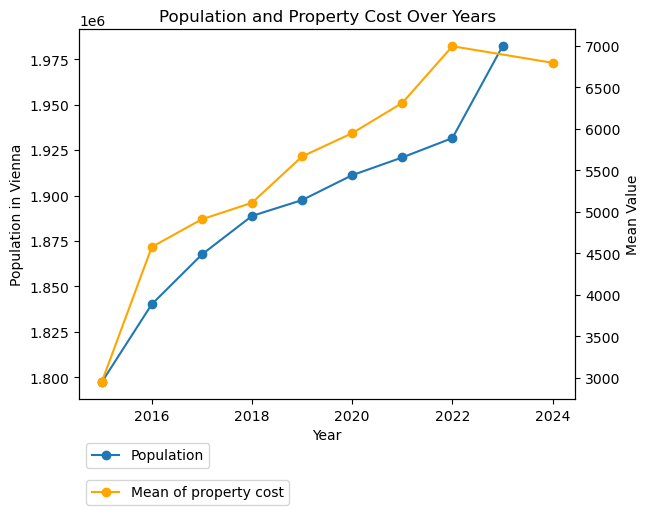

In [75]:
fig, ax = plt.subplots()

ax.plot(population['Year'], population['Population'], marker='o', label='Population')
ax.set_xlabel('Year')
ax.set_ylabel('Population in Vienna')

ax2 = ax.twinx()

ax2.plot(all_results['Year'], all_results['Median'], marker='o', label='Median of property cost', color='orange')
ax2.set_ylabel('Mean Value')

ax.legend(loc='upper left', bbox_to_anchor=(0, -0.1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, -0.2))

plt.title('Population and Property Cost Over Years')

plt.show()

Während anfangs die Eigentumskosten stärker als die Bevölkerung anstieg konnte das Bevölkerungswachstum im Jahr 2023 gepaart mit dem leichten Abfall der Eigentumskosten im Jahr 2024 dafür sorgen das über den gesamten Beobachtungszeitraum beide Anstiege in etwa gleich stark sind. Da die Anstiege innerhalb dieses Zeitraums jedoch zu unterschiedlichen Zeitpunkten erfolgt sind, heißt dies noch nicht zwangsläufig dass es sich hier auch um eine nachgewiesene Korrelation zwischen den beiden Werten handelt.

## Conclusion

Die Daten zeigen, dass es in den letzten 9 Jahren einen klaren Anstieg an Einwohnern und Eigentumskosten in der Bundeshauptstadt Wien gegeben hat. Dies hat diverse Gründe, welche nicht teil dieser Untersuchung sind und waren. Da diese Anstiege zumindest in Höhe ungefähr gleich stark sind, ist eine Korrelation nicht ausgeschlossen, sondern sogar wahrscheinlich. Dagegen würde jedoch sprechen, dass im Laufe dieser Jahre der Anstieg indivduell unterschiedlich ausgefallen ist und erst durch das starke Bevölkerungswachstum in 2023 und der Rückgang der Eigentumskosten im Jahr 2024 dafür gesorgt haben, dass die jeweiligen Anstiege in Summe ungefähr gleich stark ausfallen.
Auch muss für eine weitere Analyse berücksichtigt werden, dass die Datenquellen der Daten von 2024 und 2015-2022 unterschiedlich sind. Es kann durch diverse Faktoren dazu kommen, dass die eine oder die andere Datenquelle in eine gewisse Richtung verzerrt.

## Closing

In [36]:
spark.stop()

## Documentation

### Git Benni

Versionierung, Workflow, Code Reviews

### Spark Benni

große Datenmengen

### Kafka Benni

offen für weiter Datensourcen (aktuellen Eigentumspreisen 2024) theoretisch von mehreren Webseiten scrapen und uns einen besseren Überblick verschaffen (skalierbar)

### Streaming

Streaming kann in diesem Projekt effektiv eingesetzt werden, um z.B. kontinuierlich Kaufpreisdaten für Eigentumswohnungen pro m² in Echtzeit zu verarbeiten. Dies würde sofortige Analysen ermöglichen und schnelle Entscheidungsfindungen begünstigen. Es bietet viel Potenzial einen dynamischen Bericht aufzubauen und aktuelle Markttrends frühzeitig zu erkennen.

### Output

Die Möglichkeit die bereinigten Daten auch zwischenzeitlich zu exportieren und für weitere Auswertungen verfügbar zu machen sind breit gestreut. 
Wir haben uns der Einfachheit halber für einen csv Export entschieden, der auch in der Geschäftswelt mit Excel und Co. durchaus gang und gäbe ist. 
Unsere gewählten Datenquellen bereinigt, strukturiert und zusammen gefügt, ergeben einen homogenen Datensatz, der einen kompakten und stimmigen Überblick über die Preisveränderungen bei Eigentumswohnungen gibt und diese in Kontext mit der Bevölkerungsentwicklung stellt.